[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aussiekom/Data-Science-Basics/blob/main/EDA/Outliers-Detection/outliers_eda_code.ipynb)


In [1]:
from IPython.display import clear_output
import os
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import pandas_profiling as pp
import seaborn as sns
import scipy as sc
from scipy import stats

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA

#Mutual Information
from sklearn.feature_selection import mutual_info_regression

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

warnings.filterwarnings('ignore')

In [4]:
def load_data():
    data_dir = Path("/content")
    df = pd.read_csv(data_dir / "data.csv")
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    return df, sample_submission


# Function taken from Schubert de Abreu's work: "Enthusiast to Data Professional - What Changes ?"
"""
function annotation_helper(...)

Helper for annotations in plotly. While reducing the amount of code to create an annotation, it also:
- Allows us to provide the text into an array of
  strings(one for each new line) instead of one really long <br> separated text param
- Provides basic functionality for individual line spacing(s) between each line
- Custom annotation rectangle
- Basic debugging for annotation positioning
"""

def annotation_helper(fig, texts, x, y, line_spacing, align="left", bgcolor="rgba(0,0,0,0)", borderpad=0, ref="axes", xref="x", yref="y", width=100, debug = False):

    is_line_spacing_list = isinstance(line_spacing, list)
    total_spacing = 0

    for index, text in enumerate(texts):
        if is_line_spacing_list and index!= len(line_spacing):
            current_line_spacing = line_spacing[index]
        elif not is_line_spacing_list:
            current_line_spacing = line_spacing

        fig.add_annotation(dict(
            x= x,
            y= y - total_spacing,
            width = width,
            showarrow=False,
            text= text,
            align= align,
            borderpad=4 if debug == False else 0, # doesn't work with new background box implementation :S
            xref= "paper" if ref=="paper" else xref,
            yref= "paper" if ref=="paper" else yref,

            bordercolor= "#222",
            borderwidth= 2 if debug == True else 0 # shows the actual borders of the annotation box
        ))

        total_spacing  += current_line_spacing

    if bgcolor != "rgba(0,0,0,0)":
        fig.add_shape(type="rect",
            xref= "paper" if ref=="paper" else xref,
            yref= "paper" if ref=="paper" else yref,
            xanchor = x, xsizemode = "pixel",
            x0=-width/2, x1= +width/2, y0=y + line_spacing[-1], y1=y -total_spacing,
            fillcolor= bgcolor,
            line = dict(width=0))

    if debug == True:
        handle_annot_debug(fig, x, y, ref)

df, sample_submission = load_data()
clear_output()

### Exploratory Data Analysis

To start with, we're gonna take a brief view on the dataset given in order to get some basic information about it:

* We're gonna show some sample rows of the dataframe.
* Examine which type of features we've given
* Find out whether there are missing values or not.

In [5]:
print('Number of features: {}'.format(df.shape[1]))
print('Numerical features: {}'.format(df.select_dtypes(['float','int']).shape[1]))
print('Missing values: {}\n'.format(df.isnull().sum().sum()))
df.head()

Number of features: 30
Numerical features: 30
Missing values: 0



,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [6]:
df.drop('id',axis = 1).describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
f_00,98000.000000,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.000000,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.000000,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.000000,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.000000,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.000000,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.000000,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.000000,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.000000,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.000000,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


### Distributions

In this first section, we're gonna focus on analysing every feature's distribution and its related statistical information. To start with, let's plot the distributions in order to determine whether features are distributed normally.

We're gonna distinguish between different numerical types of features. On the one hand, **red** is going to be related to `int` features. On the other hand, **blue** is going to be used to show `float` features distributions.

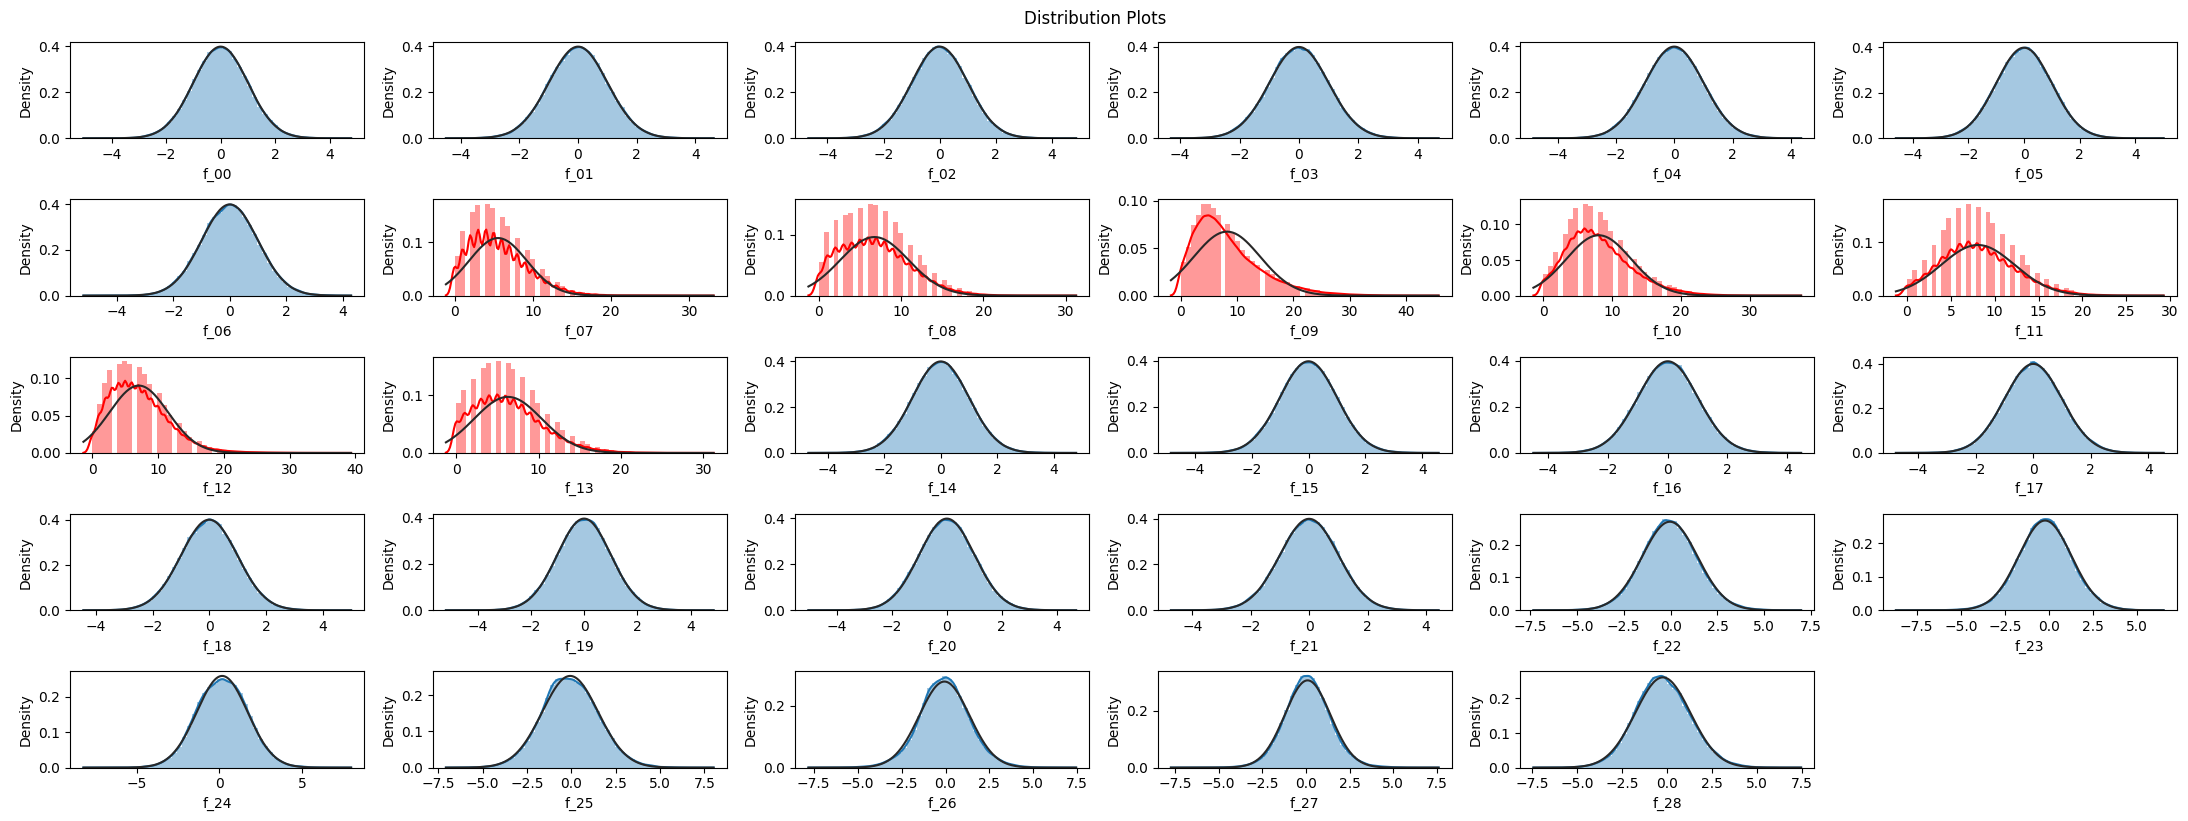

In [7]:
figure = plt.figure(figsize = (22,8))
for i in range(29):
    feature_name = 'f_0{}'.format(i) if i < 10 else 'f_{}'.format(i)
    plt.subplot(5, 6, i+1)
    if df[feature_name].dtype == 'int':
        sns.distplot(df[feature_name], fit=stats.norm, color = 'red')
    else:
        sns.distplot(df[feature_name], fit=stats.norm)
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Distribution Plots', y=1.02)
plt.show()

<div class="alert alert-block alert-info"> 📌 <b>Early insights:</b>

* It seems that every `float` feature is distributed normally. By contrast, that's not what happens when talking about `int` features.</div>

Thus, let's determine it. We can proceed with different methods. Let's show some of them:

**Shapiro-Wilk Test** (Code taken from [TPS Jul 22 Advanced. Author: Torch me](https://www.kaggle.com/code/kartushovdanil/tps-jul-22-advanced-2-sol))

This test is used to test whether a dataset is distributed normally or not. The null hypothesis is that a sample $$x_1\hspace{0.1cm},\hspace{0.1cm}\cdots\hspace{0.1cm},\hspace{0.1cm}x_n$$ comes from a normally distributed population. It was published in 1965 by Samuel Shapiro and Martin Wilk. **It is considered one of the most powerful tests for normality testing.** The test stadistic will be:

$$W = \frac{(\sum_{i=1}^{n}a_{i}x_i)^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

where

* $x_i$ is the number occupying the i-th position in the sample (with the sample ordered from smallest to largest).
* $\bar{x}$ is the sample mean.
* Variables $a_i$ are calculated this way:

$$(a_1, ... , a_n) = \frac{m^T V^{-1}}{(m^T V^{-1}V^{-1}m)^{1/2}} \hspace{2cm}m = (m_1 , ... , m_n)$$

where $m_1 , ... , m_n$ are the mean values of the ordered statistic, of independent and identically distributed random variables, sampled from normal distributions and $V$ denotes the covariance matrix of that order statistic. **The null hypothesis is rejected if W is too small. The value of W can range from 0 to 1.**

In [8]:
from scipy.stats import shapiro
from termcolor import colored

# We don't care about `id` feature column information
for col in df.columns[1:]:
    stat, p_value = shapiro(df[col])
    alpha = 0.05
    if p_value > alpha:
        result = colored('Accepted', 'green')
    else:
        result = colored('Rejected','red')
    print('Feature: {}\t Hypothesis: {}'.format(col, result))

Feature: f_00	 Hypothesis: Accepted
Feature: f_01	 Hypothesis: Accepted
Feature: f_02	 Hypothesis: Accepted
Feature: f_03	 Hypothesis: Accepted
Feature: f_04	 Hypothesis: Accepted
Feature: f_05	 Hypothesis: Accepted
Feature: f_06	 Hypothesis: Accepted
Feature: f_07	 Hypothesis: Rejected
Feature: f_08	 Hypothesis: Rejected
Feature: f_09	 Hypothesis: Rejected
Feature: f_10	 Hypothesis: Rejected
Feature: f_11	 Hypothesis: Rejected
Feature: f_12	 Hypothesis: Rejected
Feature: f_13	 Hypothesis: Rejected
Feature: f_14	 Hypothesis: Accepted
Feature: f_15	 Hypothesis: Accepted
Feature: f_16	 Hypothesis: Accepted
Feature: f_17	 Hypothesis: Accepted
Feature: f_18	 Hypothesis: Accepted
Feature: f_19	 Hypothesis: Accepted
Feature: f_20	 Hypothesis: Accepted
Feature: f_21	 Hypothesis: Accepted
Feature: f_22	 Hypothesis: Rejected
Feature: f_23	 Hypothesis: Rejected
Feature: f_24	 Hypothesis: Rejected
Feature: f_25	 Hypothesis: Rejected
Feature: f_26	 Hypothesis: Rejected
Feature: f_27	 Hypothesis: R

**Theoretical quantile charts (Q-Q charts)**

It consists of comparing the quantiles of the observed distribution with the theoretical quantiles of a normal distribution with the same mean and standard deviation as the data. The closer the data are to a normal, the more aligned the points are around the line.

> <span style='color:grey'>A quantile is that point that divides the distribution function of a random variable into regular intervals. It is therefore nothing more than a statistical technique for separating the data of a distribution.</span>

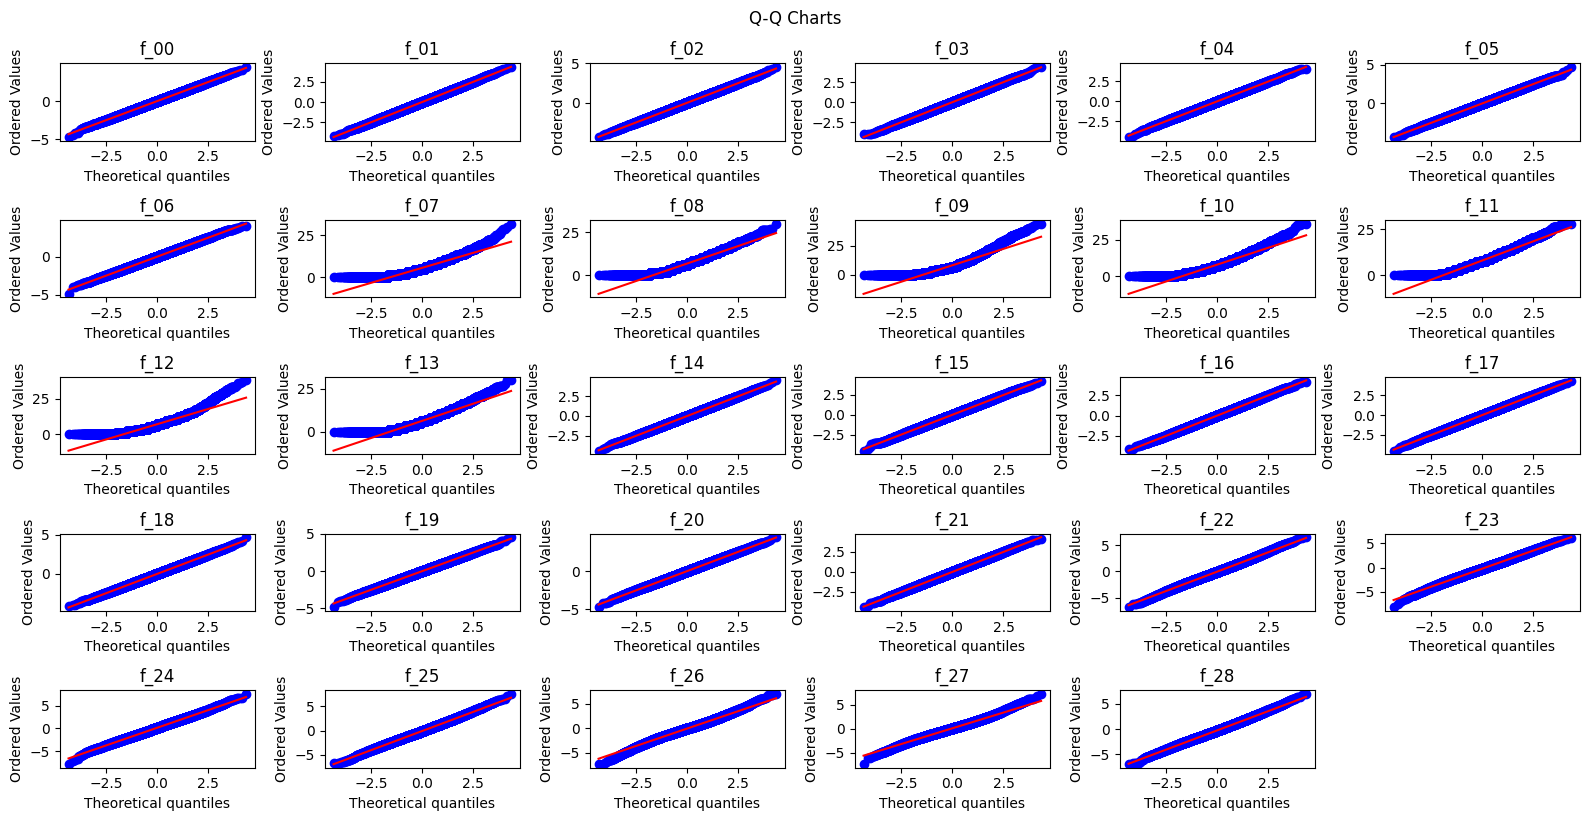

In [9]:
from scipy import stats
figure = plt.figure(figsize = (16,8))
for i in range(29):
    feature_name = 'f_0{}'.format(i) if i < 10 else 'f_{}'.format(i)
    plt.subplot(5, 6, i+1)
    stats.probplot(df[feature_name], plot=plt)
    plt.title(feature_name)
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Q-Q Charts', y=1.02)
plt.show()

### Skewness and Kurtosis

[Skewness and Kurtosis Tutorial](https://www.universoformulas.com/estadistica/descriptiva/asimetria-curtosis/)

Let's first explain **skewness**. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.

For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. In cases where one tail is long but the other tail is fat, skewness does not obey a simple rule. For example, a zero value means that the tails on both sides of the mean balance out overall; this is the case for a symmetric distribution, but can also be true for an asymmetric distribution where one tail is long and thin, and the other is short but fat. A skewness greater than 1 is generally judged to be skewed, so check mainly those greater than 1.

In [10]:
from scipy.stats import skew, kurtosis

quantitative = df.select_dtypes(['int','float']).columns[1:]
skew_features = pd.DataFrame(df[quantitative].apply(lambda x : skew(x))).reset_index()
skew_features.columns = ['features','skewness']

fig = px.bar(skew_features, x='features',y='skewness', color = 'skewness', color_continuous_scale = 'Teal')

# General Styling
fig.update_layout(height=400, bargap=0.2,
                  margin=dict(b=0, t=120),
                  plot_bgcolor='rgb(242,242,242)',
                  #paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)

#Title
text = [
    "<span style='font-size:35px; font-family:Times New Roman'>Skewness Chart</span>"
]
annotation_helper(fig, text, -0.043, 1.5, [0.095,0.095,0.065],ref="paper", width=1300)

#Subtitle
text = [
    "<span style='font-size:14px; font-family:Helvetica'> Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.</span>",
    "<span style='font-size:14px; font-family:Helvetica'> For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right</span>",
]
annotation_helper(fig, text, -0.043, 1.3, [0.075,0.05,0.065],ref="paper", width=1300)

fig.show()

Let's now move into kurtosis. In probability theory and statistics, kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes the shape of a probability distribution and there are different ways of quantifying it for a theoretical distribution and corresponding ways of estimating it from a sample from a population. Different measures of kurtosis may have different interpretations.

The standard measure of a distribution's kurtosis, originating with Karl Pearson, is a scaled version of the fourth moment of the distribution. This number is related to the tails of the distribution, not its peak; hence, the sometimes-seen characterization of kurtosis as "peakedness" is incorrect. For this measure, higher kurtosis corresponds to greater extremity of deviations (or outliers), and not the configuration of data near the mean.

In [11]:
from scipy.stats import skew, kurtosis

quantitative = df.select_dtypes(['int','float']).columns[1:]
skew_features = pd.DataFrame(df[quantitative].apply(lambda x : kurtosis(x))).reset_index()
skew_features.columns = ['features','kurtosis']

fig = px.bar(skew_features, x='features',y='kurtosis', color = 'kurtosis', color_continuous_scale = 'Teal')

# General Styling
fig.update_layout(height=400, bargap=0.2,
                  margin=dict(b=0, t=120),
                  plot_bgcolor='rgb(242,242,242)',
                  #paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)

#Title
text = [
    "<span style='font-size:35px; font-family:Times New Roman'>Kurtosis Chart</span>"
]
annotation_helper(fig, text, -0.043, 1.5, [0.095,0.095,0.065],ref="paper", width=1300)

#Subtitle
text = [
    "<span style='font-size:14px; font-family:Helvetica'> Kurtosis is a measure of the tailedness of the probability distribution of a real-valued random variable. Like skewness, it describes the shape of a probability distribution and there are different</span>",
    "<span style='font-size:14px; font-family:Helvetica'> ways of quantifying it for a theoretical distribution and corresponding ways of estimating it from a sample from a population. Different measures of kurtosis may have different interpretations.</span>",
]
annotation_helper(fig, text, -0.043, 1.3, [0.075,0.05,0.065],ref="paper", width=1300)

fig.show()

### Dimensionality Reduction. Principal Component Analysis (PCA)

One-dimension data is relatively near. However, when its dimension increases, data dimensionality becomes a problem when talking about clustering due to the following reasons:

* Adding one dimension, implies that the data is moving away.
* When we have many dimensions, measures of distance are not useful. This is called **equidistance**.

In other words the higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction. Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables. Principal component analysis (PCA) method, therefore, allows the information provided by multiple features to be "condensed" into just a few components.

### Relationships between features

A pre-requisite to apply properly PCA is that features must be correlated. Due to it, we'll start by calculating their correlation coefficients and showing them in a heatmap chart. Thus, we'll be able to determine which features are linearly related.

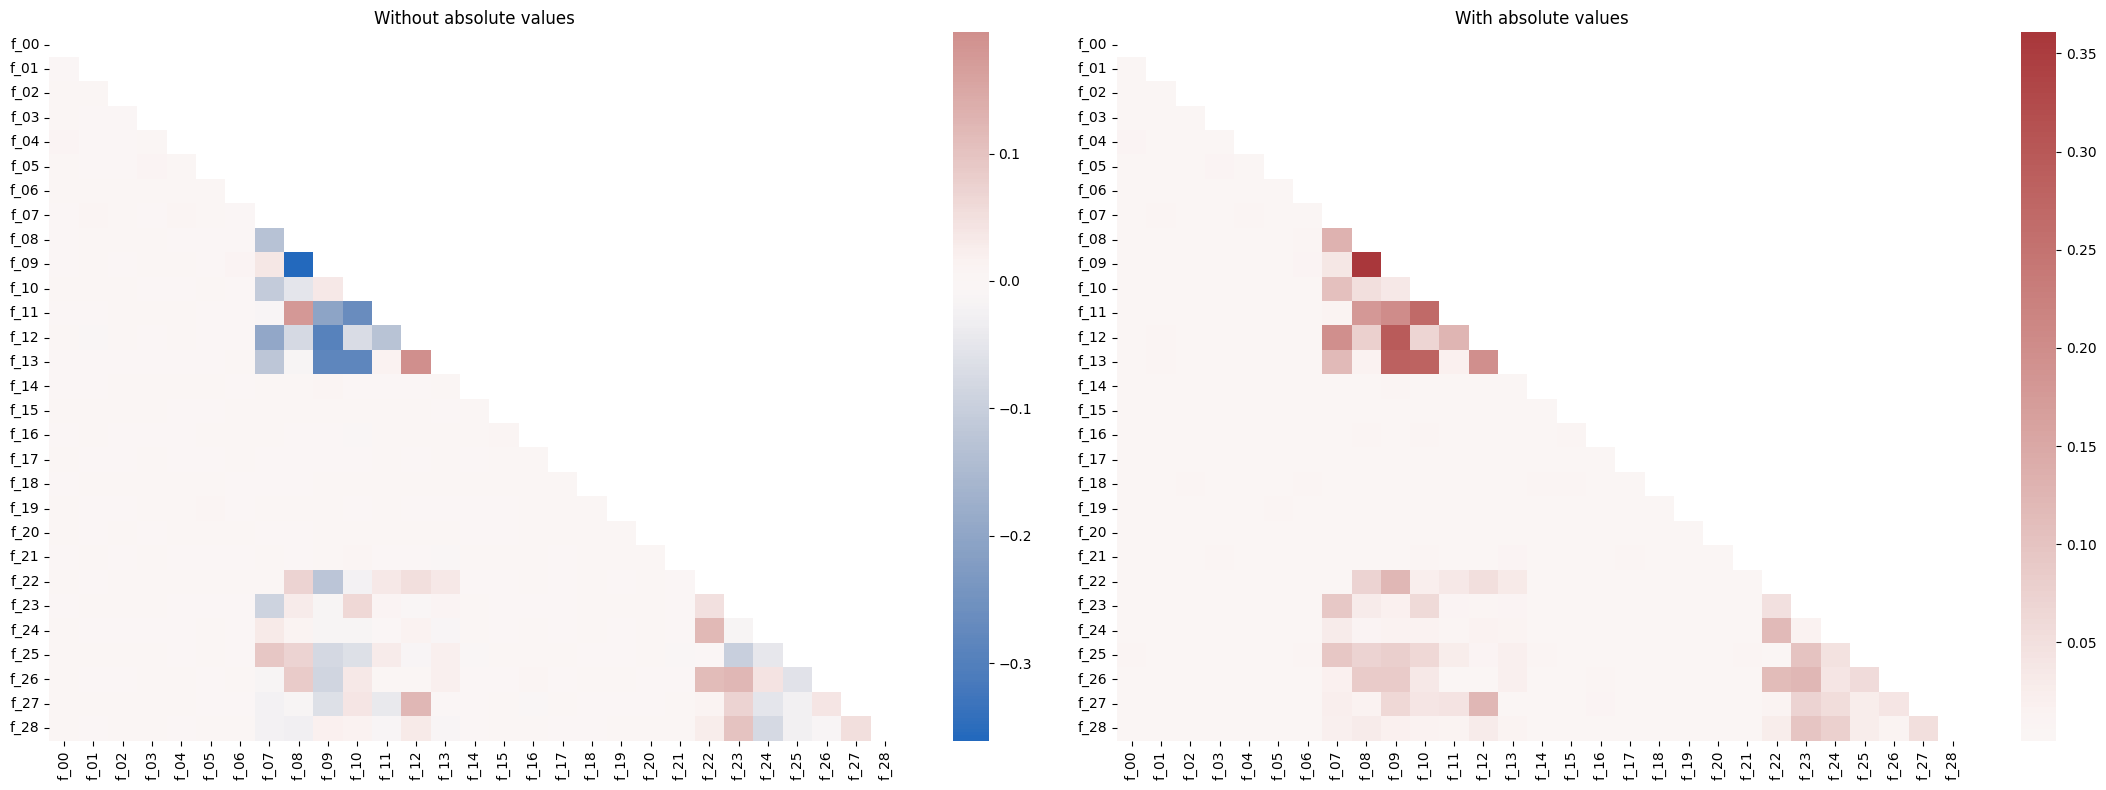

In [12]:
corr= df.loc[:,'f_00':].corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22,8))
# Heatmap without absolute values
sns.heatmap(corr, mask=matrix, center = 0, cmap = 'vlag', ax = axes[0]).set_title('Without absolute values')
# Heatmap with absolute values
sns.heatmap(abs(corr), mask=matrix, center = 0, cmap = 'vlag', ax = axes[1]).set_title('With absolute values')

fig.tight_layout(h_pad=1.0, w_pad=0.5)

<div class="alert alert-block alert-info"> 📌 <b>Insights:</b>

* It seems that `int` features are the ones having **higher** correlation coefficients.
* When talking about `float` features, if we recap which features are normally distributed we notice that those which were not are the ones having non-null correlation values. All of them between them. With normally distributed features they're not correlated.
* **Most correlated features** are `f_09` and `f_08`. They're inversely related.</div>

### Applying PCA

After checking that there are some features that are correlated, we're going to proceed to apply dimensionality reduction. Since the aim of PCA is to reduce dimensionality, it is often of interest to use the minimum number of components that are sufficient to explain the data. There is no single answer or method to identify the optimal number of principal components to use. A widespread approach is to assess the proportion of cumulative explained variance and select the minimum number of components beyond which the increase is no longer substantial.

In [13]:
from sklearn.preprocessing import *
from sklearn.decomposition import PCA

def apply_pca(X, transformer = False, components = -1):
    aux = X.copy()
    if transformer:
        X = pd.DataFrame(transformer.fit_transform(X))
        X.columns = aux.columns
    # Create principal components
    if components == -1:
        pca = PCA()
    else:
        pca = PCA(n_components = components)

    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize = (22,5))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    explainedVariance = pca.explained_variance_ratio_

    axs[0].bar(grid, explainedVariance)
    axs[0].set(
        xlabel="Component", title="% Explained Variance"
    )
    # Cumulative Variance
    cv = np.cumsum(explainedVariance)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance"
    )
    # Set up figure
    #fig.set(figwidth=8, dpi=100)
    fig.tight_layout(h_pad=1.0, w_pad=0.5)
    return axs

**Scaling our Data**

> [Comparison between Scalers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

To scale our data we have several transformers. We need to choose the one that fits better the algorithm we're gonna use.

* **StandardScaler:** it standardizes features by removing the mean and scaling to unit variance. Thus, each column will have mean 0 and standard deviation 1.

* **RobustScaler:** scale features using statistics that are **<span style = 'color:red'>robust to outliers</span>**. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
* **PowerTransformer:** apply a power transform featurewise to **<span style = 'color:red'>make data more Gaussian-like</span>**. Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

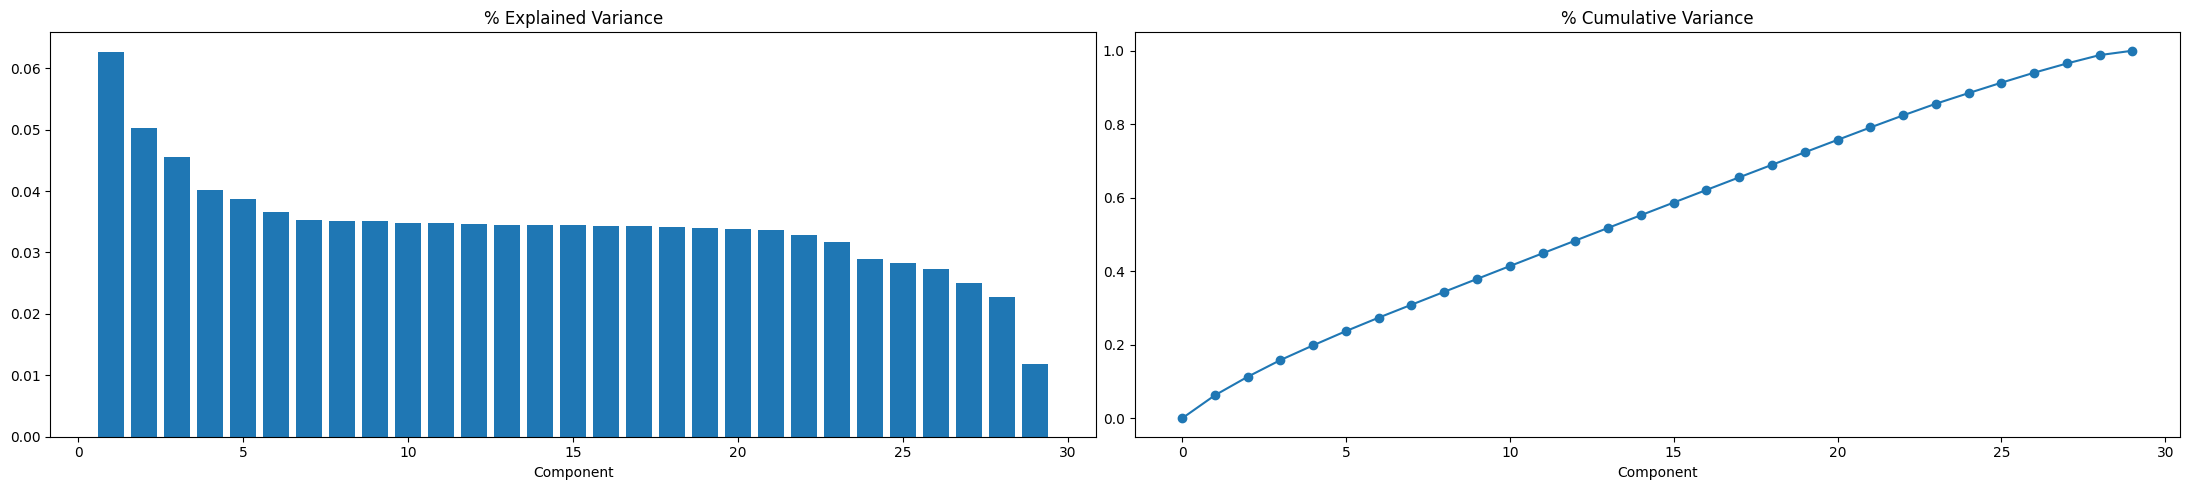

In [14]:
# Scaling our data
scaled_data = pd.DataFrame(StandardScaler().fit_transform(df.drop('id', axis = 1)))
scaled_data.columns = df.columns[1:]

X = df.drop('id', axis = 1).copy()
pca, X_pca, loadings = apply_pca(X, StandardScaler())
plot_variance(pca)

### Outlier Detection

As we mentioned in **section 1.3**, there are some clustering algorithms that are vulnerable to outliers' presence. If there is an outlier in the sample, even though it does not really belong to any group, the algorithm will assign it to one of them, causing a significant distortion of the cluster in question.

#### Univariate Outliers

**Grubbs Test**

$$
\begin{array}{l}{\text { Grubbs' test is defined for the hypothesis: }} \\ {\begin{array}{ll}{\text { Ho: }}  {\text { There are no outliers in the data set }} \\ {\mathrm{H}_{\mathrm{1}} :}  {\text { There is exactly one outlier in the data set }}\end{array}}\end{array}
$$
$$
\begin{array}{l}{\text {The Grubbs' test statistic is defined as: }} \\ {\qquad G_{calculated}=\frac{\max \left|X_{i}-\overline{X}\right|}{SD}} \\ {\text { with } \overline{X} \text { and } SD \text { denoting the sample mean and standard deviation, respectively. }} \end{array}
$$
$$
G_{critical}=\frac{(N-1)}{\sqrt{N}} \sqrt{\frac{\left(t_{\alpha /(2 N), N-2}\right)^{2}}{N-2+\left(t_{\alpha /(2 N), N-2}\right)^{2}}}
$$
$$
\begin{array}{l}{\text { If the calculated value is greater than critical, you can reject the null hypothesis and conclude that one of the values is an outlier }}\end{array}$$

In [15]:
import scipy.stats as stats

def grubbs_test(x, feature):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    if g_critical > g_calculated:
        result = colored('Accepted', 'green')
        outlier_presence = False
    else:
        result = colored('Rejected','red')
        outlier_presence = True

    print('Feature: {}\t Hypothesis: {}'.format(feature, result))
    return outlier_presence

outliers_features = []
for col in df.drop('id',axis = 1).columns:
    if grubbs_test(df[col], col):
        outliers_features.append(col)

Feature: f_00	 Hypothesis: Accepted
Feature: f_01	 Hypothesis: Accepted
Feature: f_02	 Hypothesis: Accepted
Feature: f_03	 Hypothesis: Accepted
Feature: f_04	 Hypothesis: Accepted
Feature: f_05	 Hypothesis: Accepted
Feature: f_06	 Hypothesis: Accepted
Feature: f_07	 Hypothesis: Rejected
Feature: f_08	 Hypothesis: Rejected
Feature: f_09	 Hypothesis: Rejected
Feature: f_10	 Hypothesis: Rejected
Feature: f_11	 Hypothesis: Accepted
Feature: f_12	 Hypothesis: Rejected
Feature: f_13	 Hypothesis: Rejected
Feature: f_14	 Hypothesis: Accepted
Feature: f_15	 Hypothesis: Accepted
Feature: f_16	 Hypothesis: Accepted
Feature: f_17	 Hypothesis: Accepted
Feature: f_18	 Hypothesis: Accepted
Feature: f_19	 Hypothesis: Accepted
Feature: f_20	 Hypothesis: Accepted
Feature: f_21	 Hypothesis: Accepted
Feature: f_22	 Hypothesis: Accepted
Feature: f_23	 Hypothesis: Rejected
Feature: f_24	 Hypothesis: Rejected
Feature: f_25	 Hypothesis: Accepted
Feature: f_26	 Hypothesis: Rejected
Feature: f_27	 Hypothesis: R

In [16]:
# Thus, the following features have outliers on their data
np.transpose(outliers_features)

array(['f_07', 'f_08', 'f_09', 'f_10', 'f_12', 'f_13', 'f_23', 'f_24',
       'f_26', 'f_27'], dtype='<U4')

**Z-score method**

Using Z score method,we can find out how many standard deviations value away from the mean.

![minipic](https://i.pinimg.com/originals/cd/14/73/cd1473c4c82980c6596ea9f535a7f41c.jpg)

 Figure in the left shows area under normal curve and how much area that standard deviation covers.
* 68% of the data points lie between + or - 1 standard deviation.
* 95% of the data points lie between + or - 2 standard deviation
* 99.7% of the data points lie between + or - 3 standard deviation

$\begin{array}{l} {R.Z.score=\frac{0.6745*( X_{i} - Median)}{MAD}}  \end{array}$

If the z score of a data point is more than 3 (because it cover 99.7% of area), it indicates that the data value is quite different from the other values. It is taken as outliers.

In [17]:
def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    row = 0
    for i in df:
        z = (i-m)/sd
        if np.abs(z) > 3:
            out.append(row)
        row += 1
    return out

for col in outliers_features:
    percentage = round(100 * len(Zscore_outlier(df[col])) / df.shape[0], 2)
    print('Feature: {} \tPercentage of outliers: {}%'.format(col, percentage))

Feature: f_07 	Percentage of outliers: 0.76%
Feature: f_08 	Percentage of outliers: 0.37%
Feature: f_09 	Percentage of outliers: 1.41%
Feature: f_10 	Percentage of outliers: 0.71%
Feature: f_12 	Percentage of outliers: 0.95%
Feature: f_13 	Percentage of outliers: 0.7%
Feature: f_23 	Percentage of outliers: 0.39%
Feature: f_24 	Percentage of outliers: 0.33%
Feature: f_26 	Percentage of outliers: 0.6%
Feature: f_27 	Percentage of outliers: 0.64%


**Isolation Forest**

[Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) is implemented in scikit-learn.
Isolation forest is an algorithm to detect outliers. It partitions the data using a set of trees and provides an anomaly score looking at how isolated the point is in the structure found. The anomaly score is then used to tell apart outliers from normal observations.
An important concept in this method is the isolation number. The isolation number is the number of splits needed to isolate a data point. This number of splits is ascertained by following these steps:

* A point “a” to isolate is selected randomly.
* A random data point “b” is selected that is between the minimum and maximum value and different from “a”.
* If the value of “b” is lower than the value of “a”, the value of “b” becomes the new lower limit.
* If the value of “b” is greater than the value of “a”, the value of “b” becomes the new upper limit.
* This procedure is repeated as long as there are data points other than “a” between the upper and the lower limit.

It requires fewer splits to isolate an outlier than it does to isolate a non-outlier, i.e. an outlier has a lower isolation number in comparison to a non-outlier point. A data point is therefore defined as an outlier if its isolation number is lower than the threshold. The threshold is defined based on the estimated percentage of outliers in the data, which is the starting point of this outlier detection algorithm.

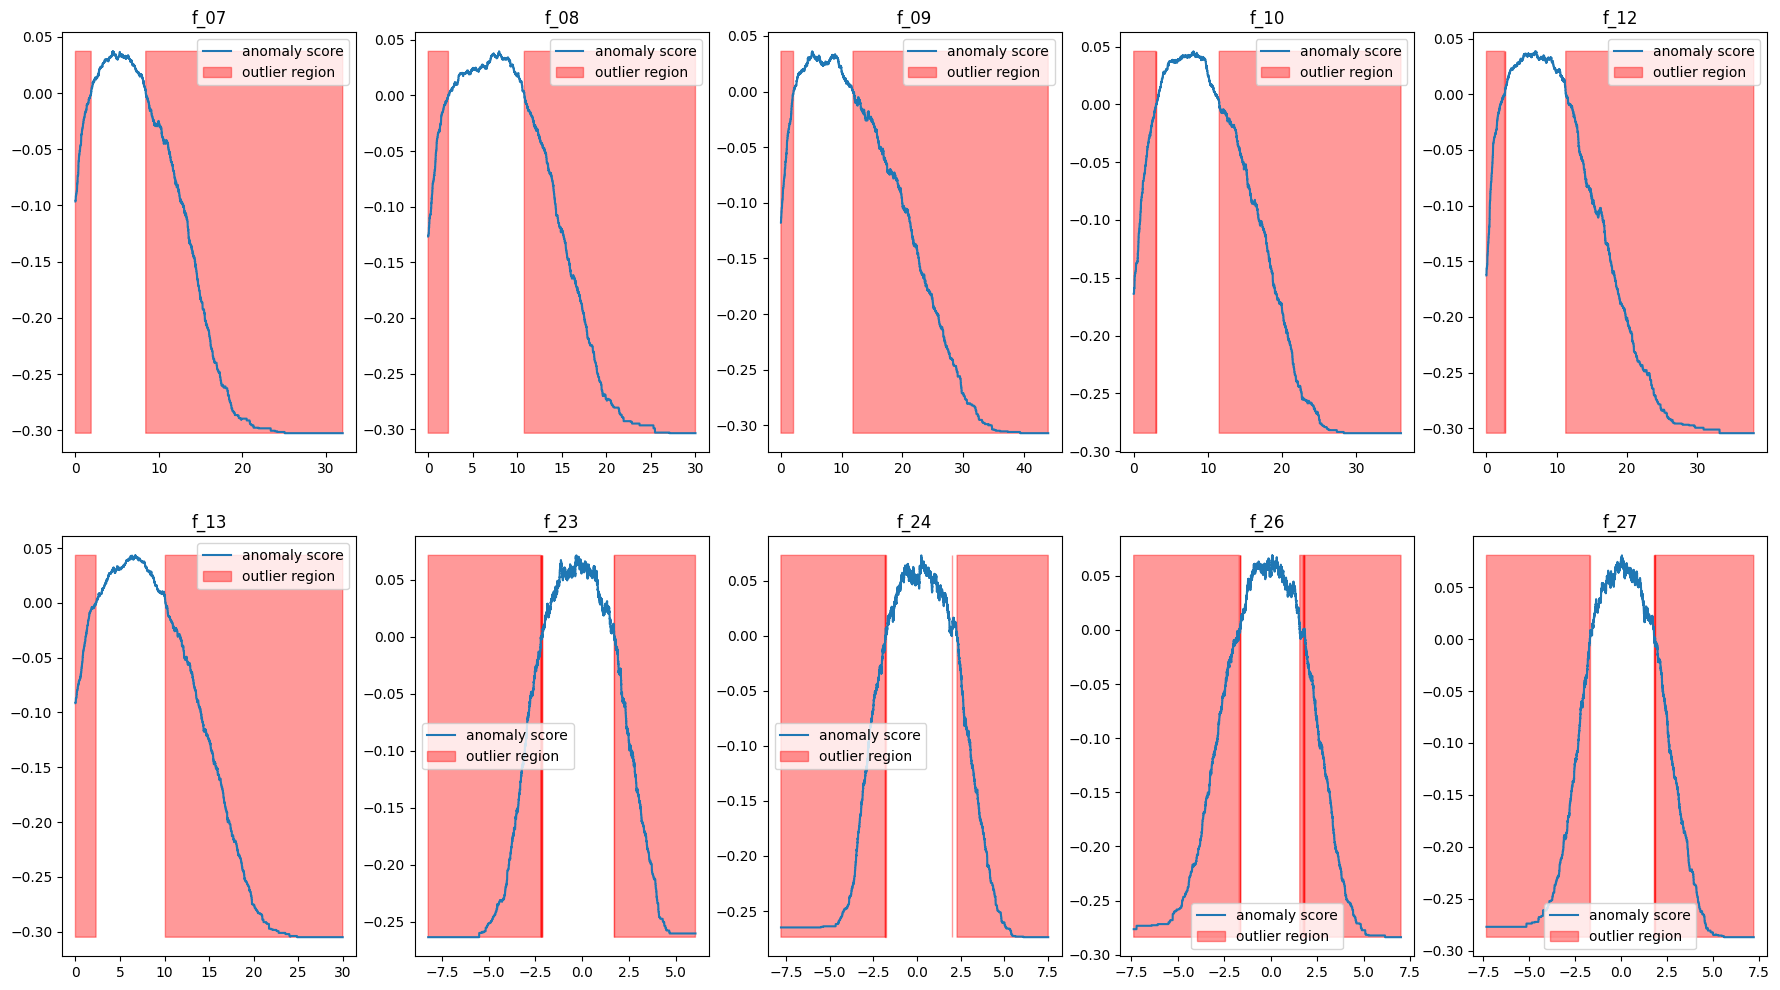

In [18]:
from sklearn.ensemble import IsolationForest

fig, axs = plt.subplots(2, 5, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(df[outliers_features].columns):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)

    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                     where=outlier==-1, color='r',
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

#### Multivariate Outliers

In many cases multivariate observations cannot be detected as outliers when each variable is considered independently. The detection of outliers is only possible when a multivariate analysis is performed and the interactions between the different variables are compared within the data class.

**2-Dimensional Outliers. Mahalanobis Distance**

Due to the amount of charts and information, I'll hide the output as well. Just to let you know it. **I've analysing outliers and I have noticed that there're mainly two features involved in this issue. Those features are: `f_07` and `f_12`. Let's take a look on it. Let's start with `f_07`:**

> [Article](https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3)

f0 - f7 	Index of Outliers:  [28772 34766 95332]


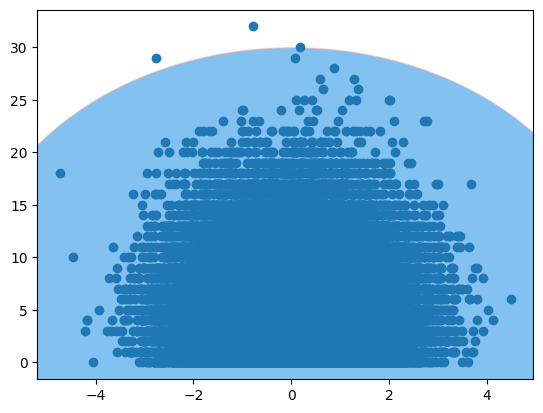

f1 - f7 	Index of Outliers:  [34766 95332]


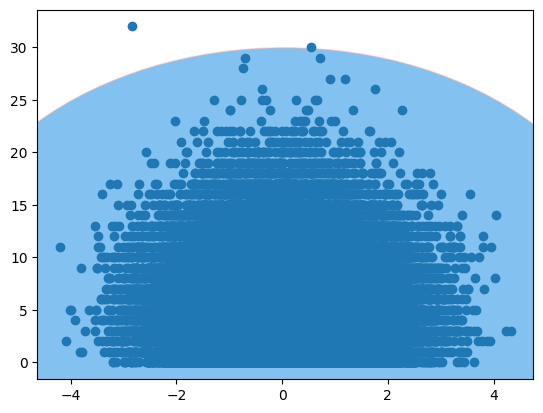

f2 - f7 	Index of Outliers:  [34766 95332]


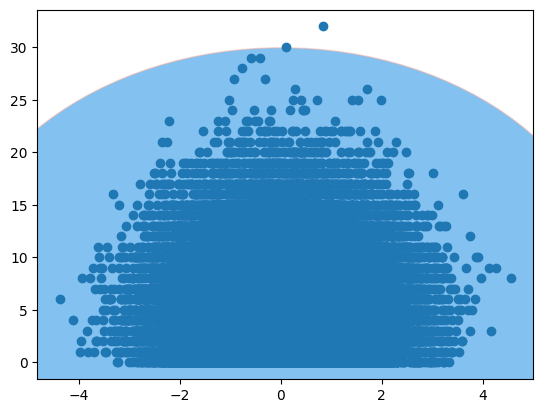

f3 - f7 	Index of Outliers:  [34766 95332]


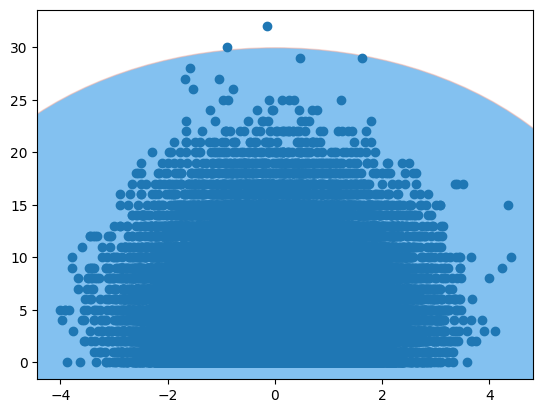

f4 - f7 	Index of Outliers:  [34766 95332]


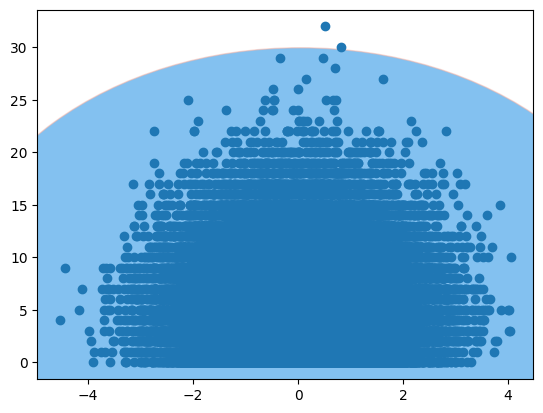

f5 - f7 	Index of Outliers:  [34766 95332]


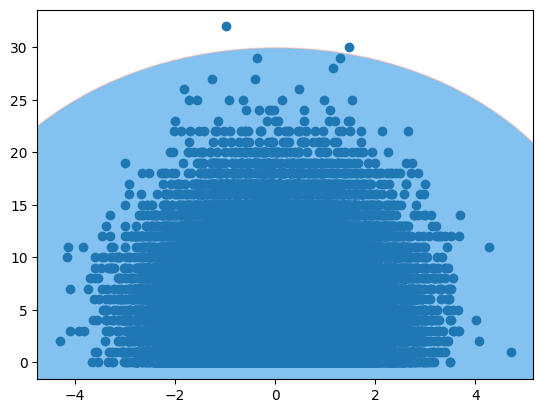

f6 - f7 	Index of Outliers:  [28772 34766 95332]


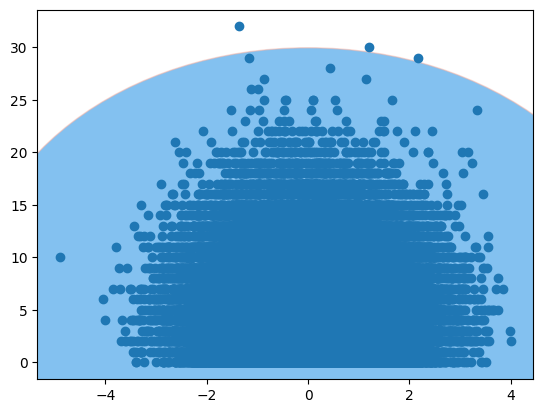

f8 - f7 	Index of Outliers:  [34766 95332]


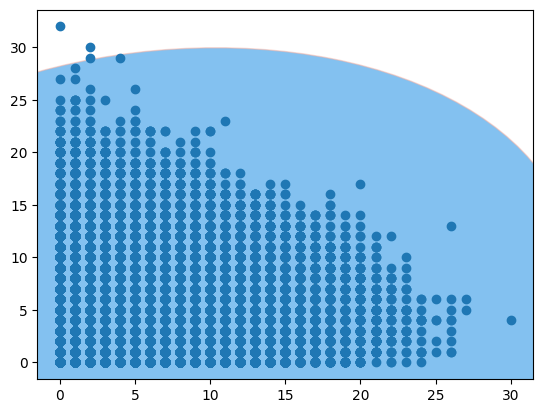

f9 - f7 	Index of Outliers:  [34766 95332]


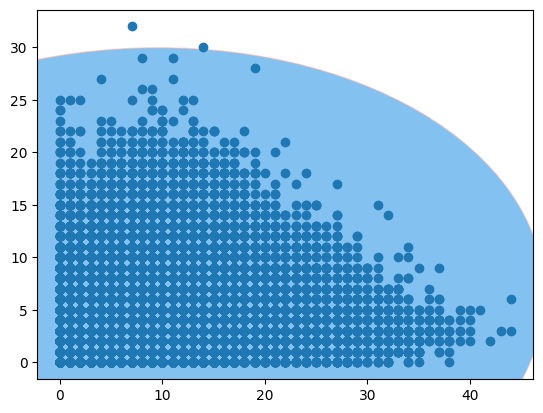

f10 - f7 	Index of Outliers:  [34766 95332]


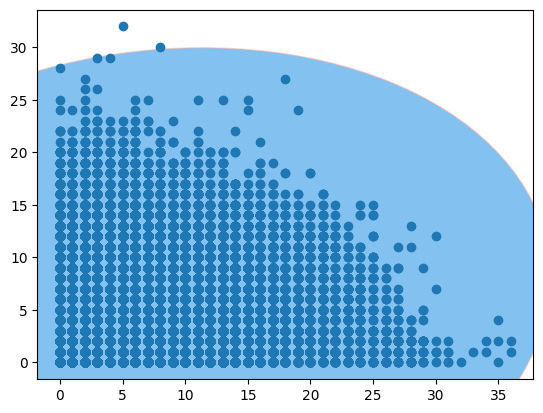

f11 - f7 	Index of Outliers:  [28772 34766 95332]


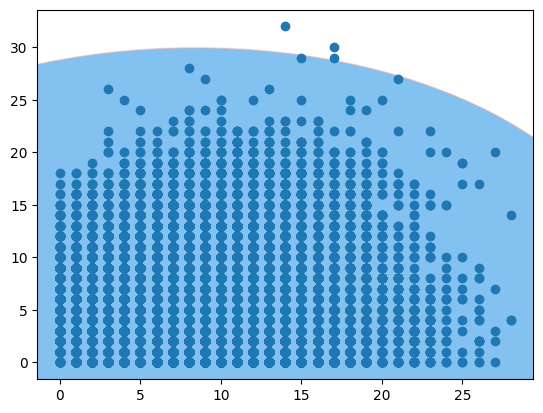

f12 - f7 	Index of Outliers:  [10925 34766 55654 95332]


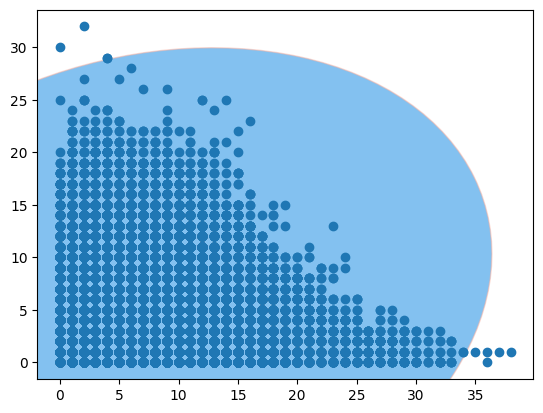

f13 - f7 	Index of Outliers:  [34766 95332]


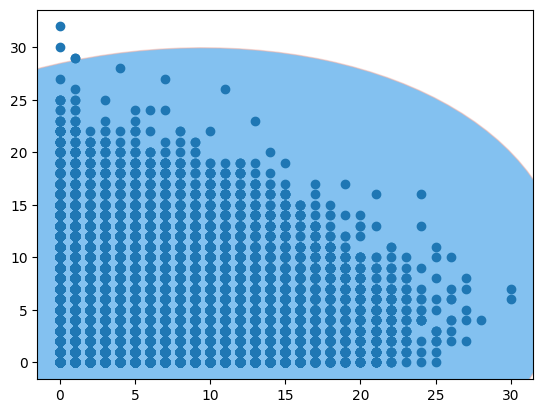

f14 - f7 	Index of Outliers:  [34766 95332]


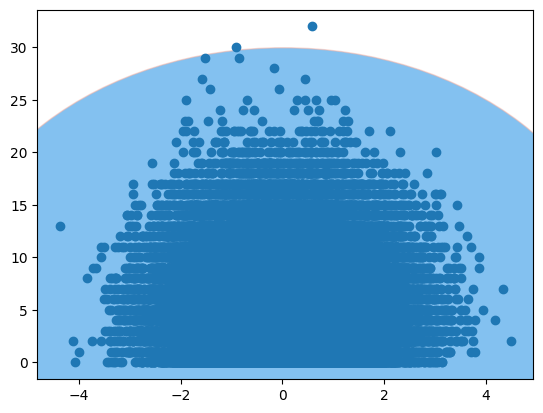

f15 - f7 	Index of Outliers:  [34766 95332]


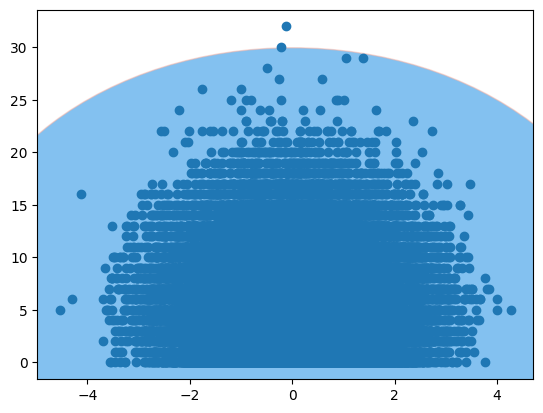

f16 - f7 	Index of Outliers:  [28772 34766 54730 95332]


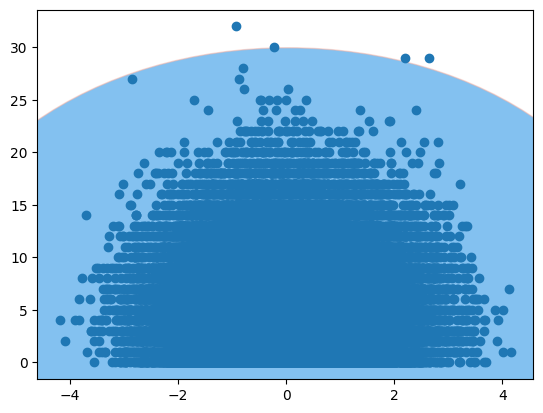

f17 - f7 	Index of Outliers:  [34766 95332]


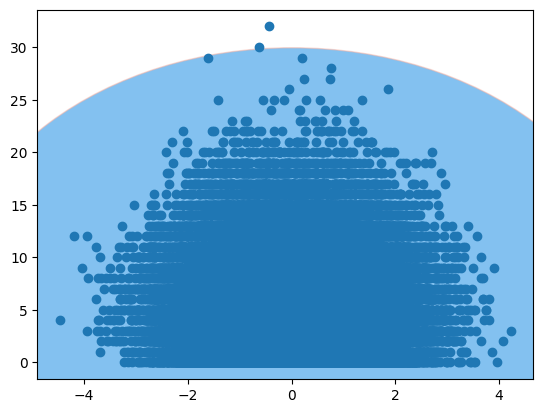

f18 - f7 	Index of Outliers:  [34766 95332]


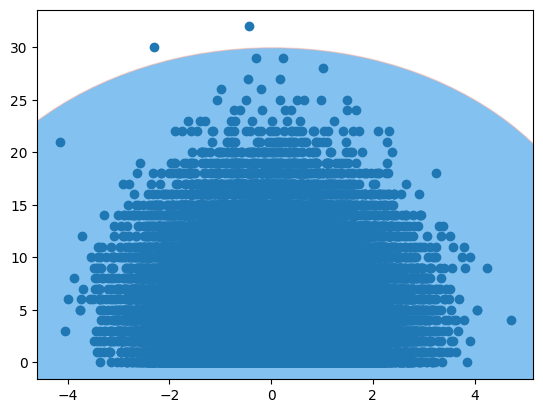

f19 - f7 	Index of Outliers:  [34766 95332]


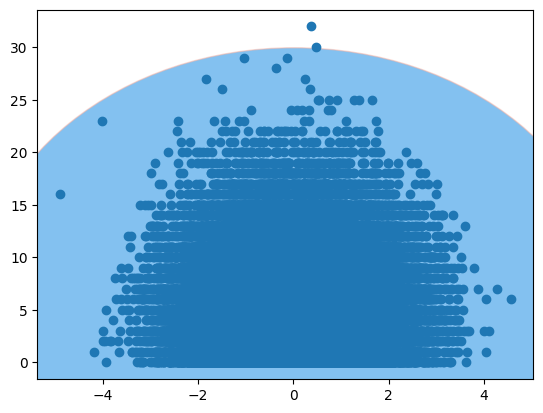

f20 - f7 	Index of Outliers:  [34766 95332]


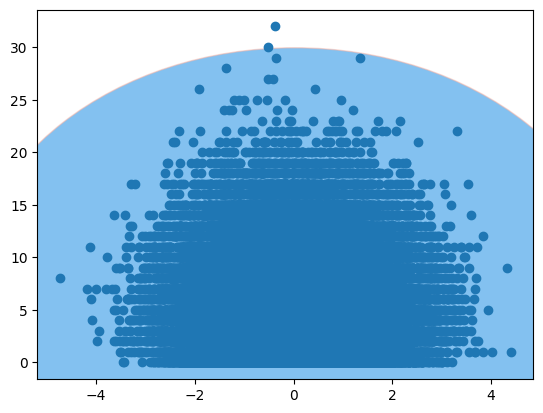

f21 - f7 	Index of Outliers:  [34766 95332]


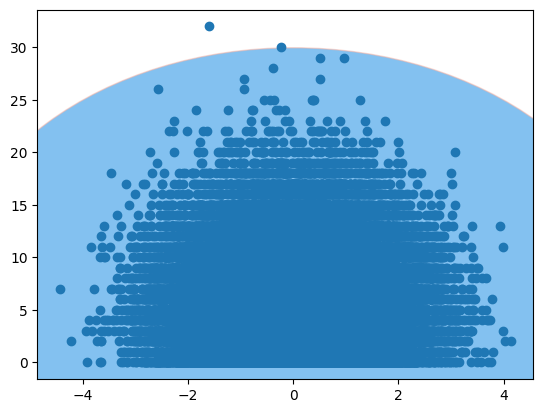

f22 - f7 	Index of Outliers:  [34766 95332]


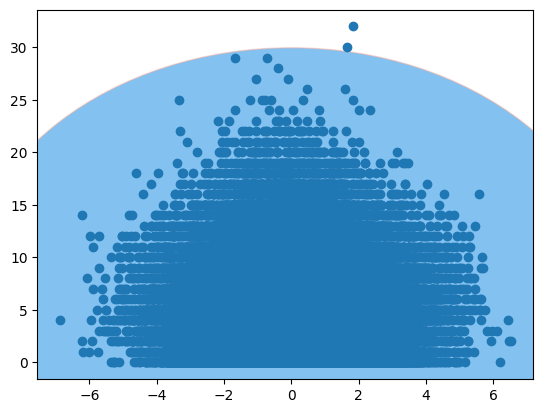

f23 - f7 	Index of Outliers:  [34766 95332]


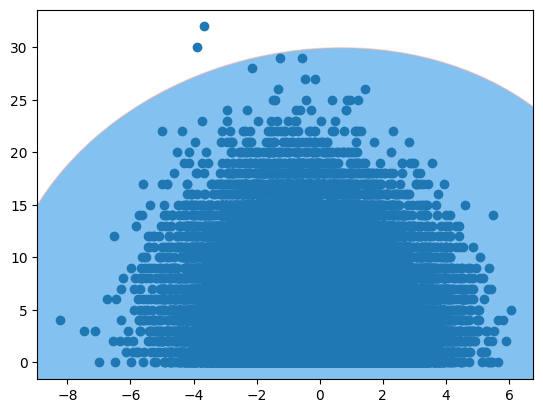

f24 - f7 	Index of Outliers:  [34766 95332]


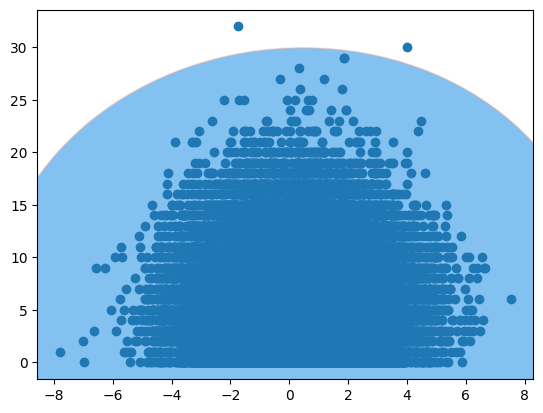

f25 - f7 	Index of Outliers:  [34766 95332]


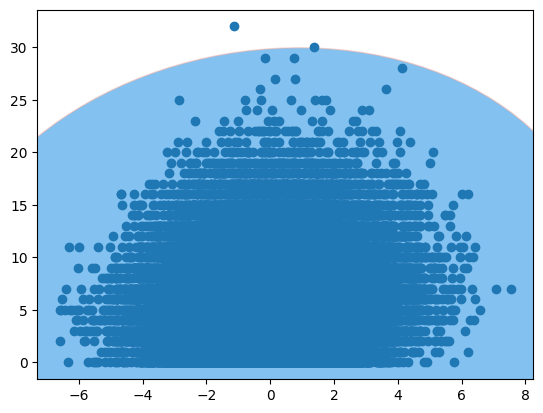

f26 - f7 	Index of Outliers:  [34766 95332]


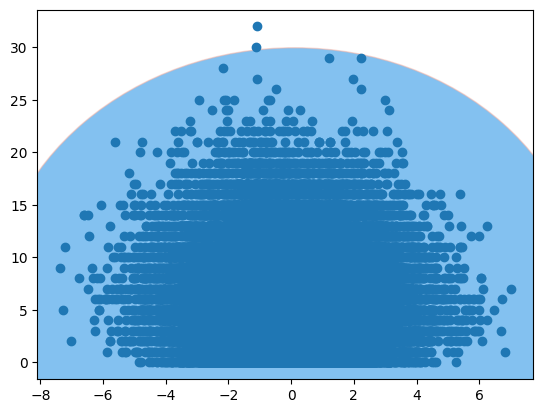

f27 - f7 	Index of Outliers:  [34766 95332]


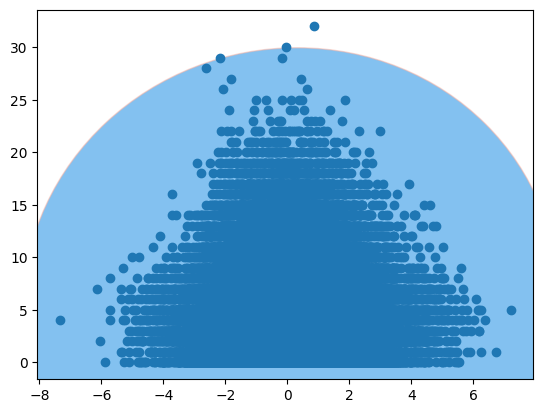

In [19]:
from scipy.stats import chi2
from matplotlib import patches

# Code taken from the article.
def mahalanobis_distance(df, f1, f2):
    df_copy = df.drop('id', axis = 1).copy()

    new_col = []
    for i in range(len(df_copy.columns)):
        new_col.append('f{}'.format(i))

    df_copy.columns = new_col

    df_copy = df_copy[[f1, f2]]
    df_copy = df_copy.to_numpy()

    # Covariance matrix
    covariance  = np.cov(df_copy , rowvar=False)

    # Covariance matrix power of -1
    covariance_pm1 = np.linalg.matrix_power(covariance, -1)

    # Center point
    centerpoint = np.mean(df_copy , axis=0)

    # Distances between center point and
    distances = []
    for i, val in enumerate(df_copy):
          p1 = val
          p2 = centerpoint
          distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
          distances.append(distance)
    distances = np.array(distances)

    # Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers
    cutoff = chi2.ppf(0.95, df.shape[1])

    # Index of outliers
    outlierIndexes = np.where(distances > cutoff )

    if(len(df_copy[ distances > cutoff , :]) > 0):
        print('{} - {}'.format(f1, f2), '\tIndex of Outliers: ', outlierIndexes[0])
        ## Finding ellipse dimensions
        pearson = covariance[0, 1]/np.sqrt(covariance[0, 0] * covariance[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        lambda_, v = np.linalg.eig(covariance)
        lambda_ = np.sqrt(lambda_)

        # Ellipse patch
        ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                          width=lambda_[0]*np.sqrt(cutoff)*2, height=lambda_[1]*np.sqrt(cutoff)*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#fab1a0')
        ellipse.set_facecolor('#0984e3')
        ellipse.set_alpha(0.5)
        fig = plt.figure()
        ax = plt.subplot()
        ax.add_artist(ellipse)
        plt.scatter(df_copy[: , 0], df_copy[ : , 1])
        plt.show()

for i in range(28):
    if i != 7:
        f1 = 'f{}'.format(i)
        mahalanobis_distance(df, f1, 'f7')

<div class="alert alert-block alert-info"> 📌 <b>Insights:</b>

* We appreciate that there are 2-dimensional outliers for each pair of features containing `f7`. Each of them has in common two samples, the ones with value greater or equal to 30 for `f7` feature.    

f0 - f12 	Index of Outliers:  [10925 55654]


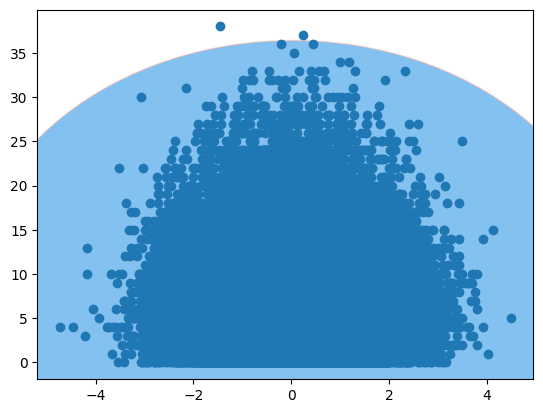

f1 - f12 	Index of Outliers:  [10925 55654]


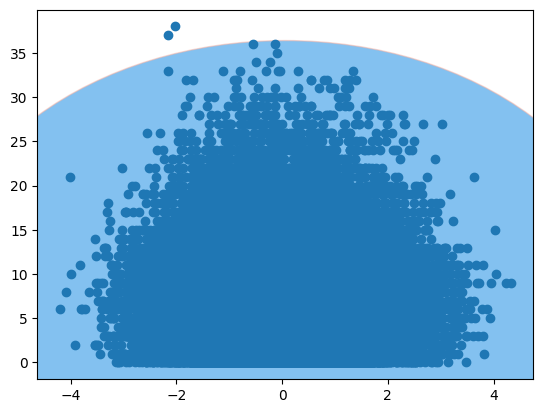

f2 - f12 	Index of Outliers:  [10925 54906 55654]


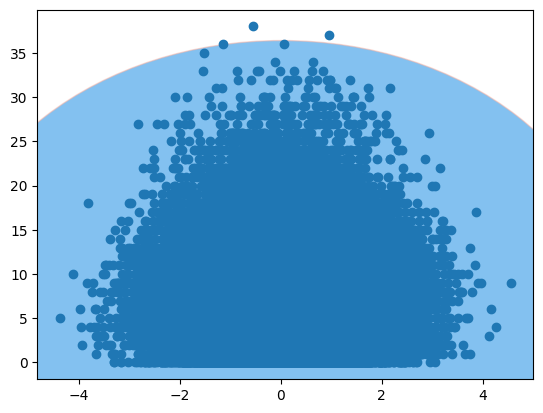

f3 - f12 	Index of Outliers:  [ 2970 10925 54906 55654]


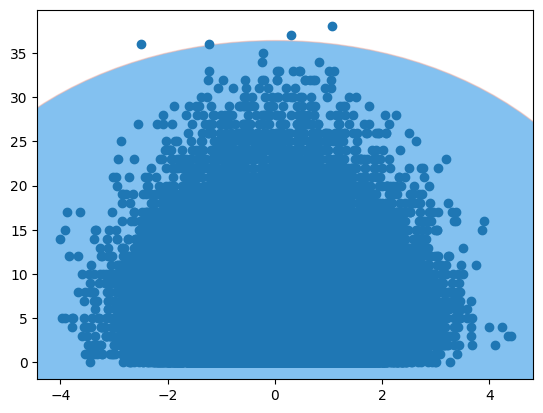

f4 - f12 	Index of Outliers:  [10925 54906 55654]


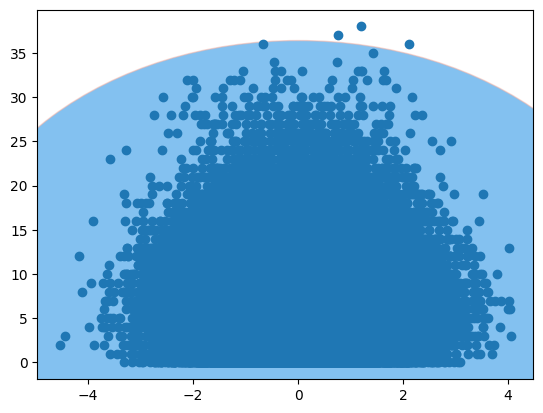

f5 - f12 	Index of Outliers:  [ 2970 10925 21949 55654]


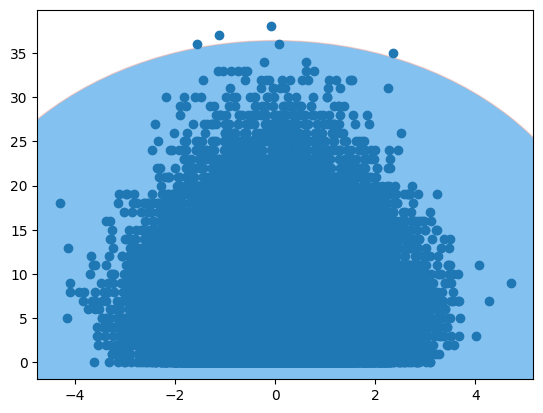

f6 - f12 	Index of Outliers:  [10925 55654]


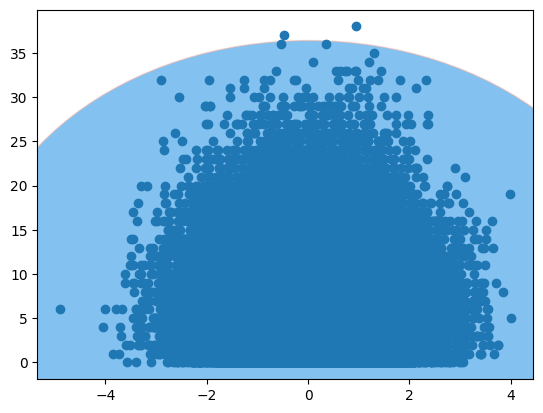

f7 - f12 	Index of Outliers:  [10925 34766 55654 95332]


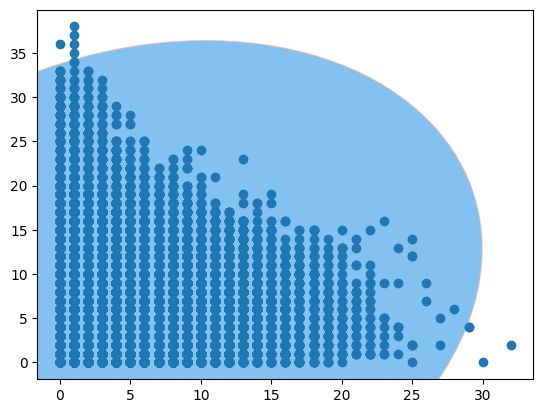

f8 - f12 	Index of Outliers:  [10925 55654]


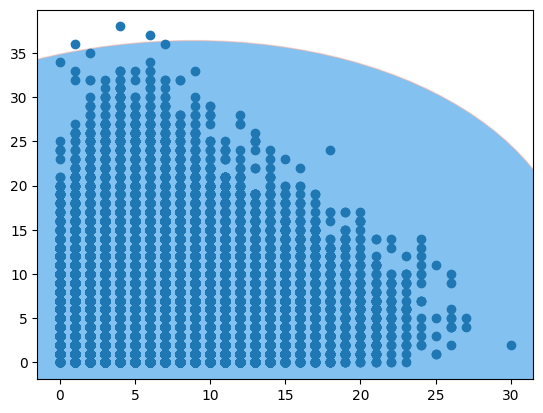

f9 - f12 	Index of Outliers:  [10925 55654]


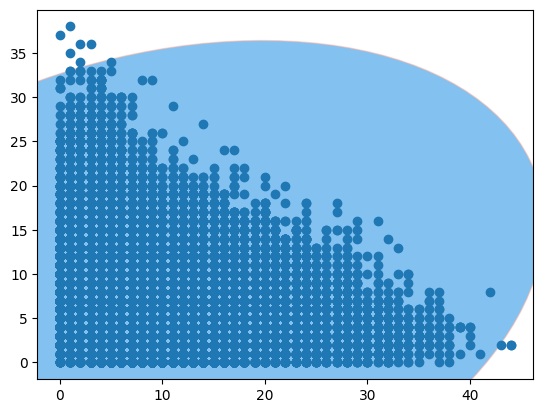

f10 - f12 	Index of Outliers:  [10925 55654]


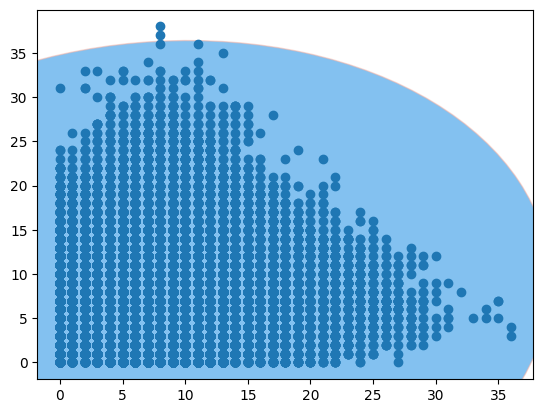

f11 - f12 	Index of Outliers:  [10925 55654]


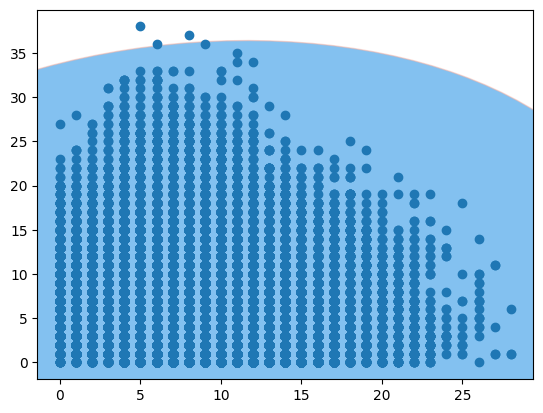

f13 - f12 	Index of Outliers:  [ 2970 10925 54906 55654]


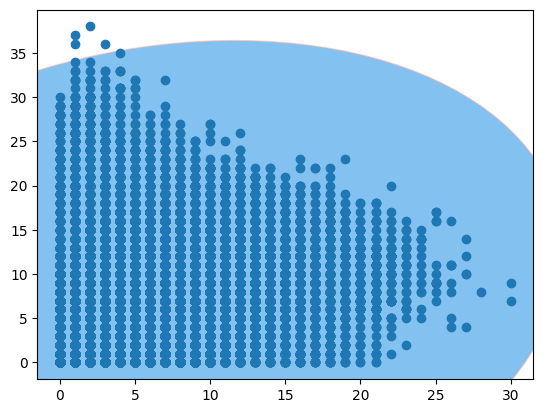

f14 - f12 	Index of Outliers:  [10925 55654]


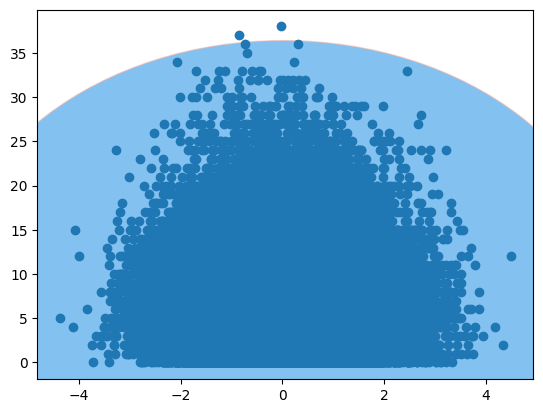

f15 - f12 	Index of Outliers:  [10925 55654]


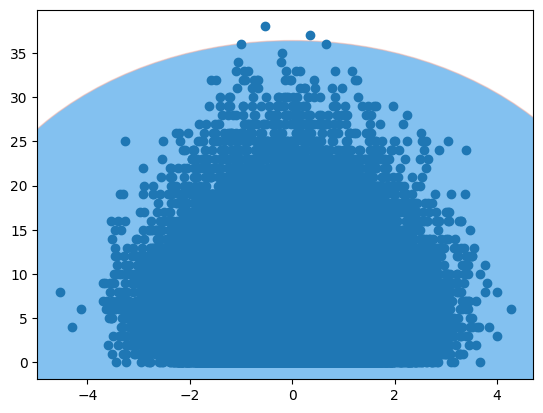

f16 - f12 	Index of Outliers:  [10925 55654]


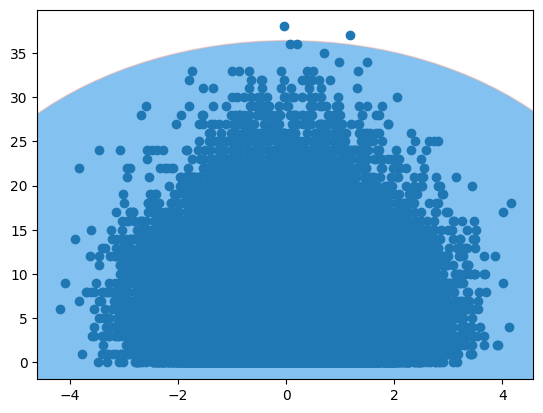

f17 - f12 	Index of Outliers:  [10925 55654]


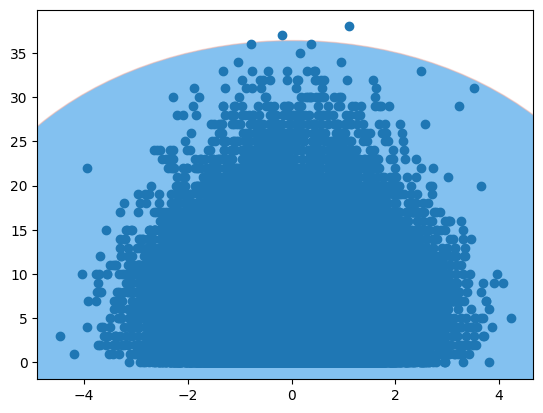

f18 - f12 	Index of Outliers:  [10925 55654]


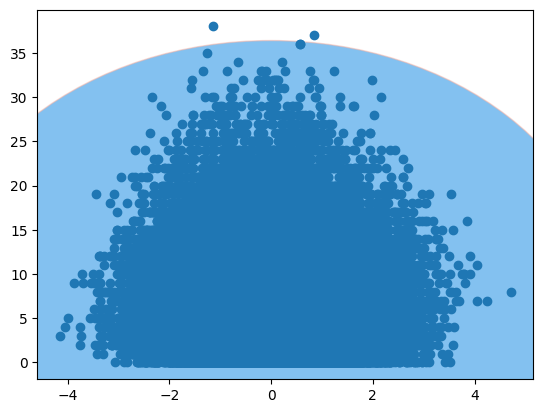

f19 - f12 	Index of Outliers:  [ 2970 10925 55654]


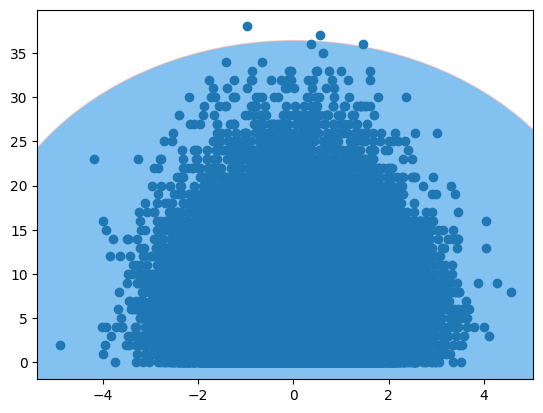

f20 - f12 	Index of Outliers:  [ 2970 10925 55654]


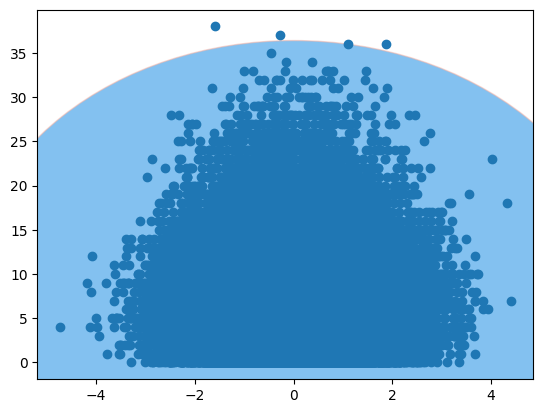

f21 - f12 	Index of Outliers:  [10925 55654]


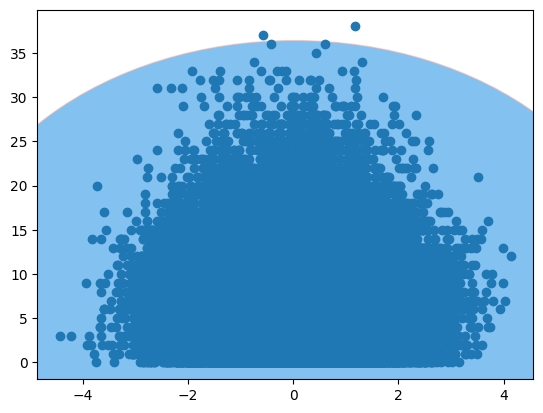

f22 - f12 	Index of Outliers:  [10925 55654]


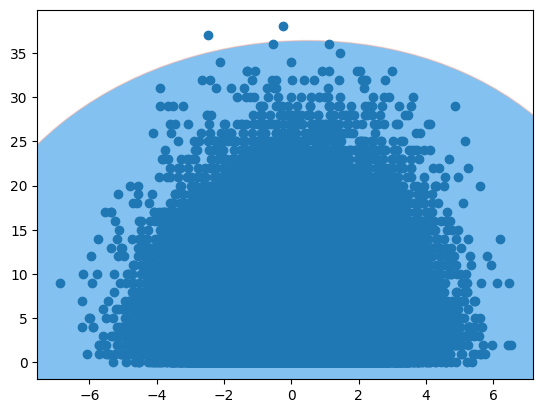

f23 - f12 	Index of Outliers:  [ 2970 10925 55654]


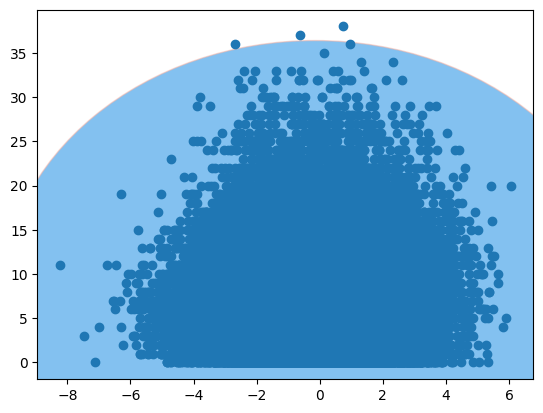

f24 - f12 	Index of Outliers:  [10925 55654]


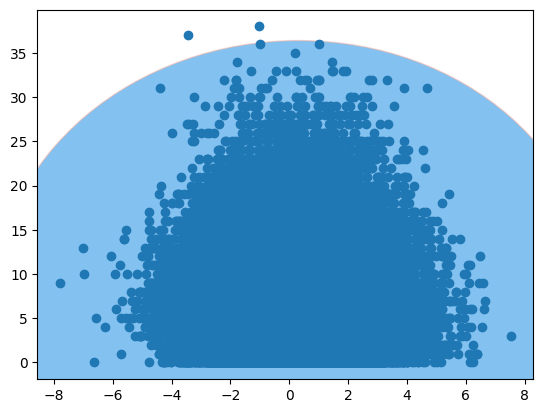

f25 - f12 	Index of Outliers:  [10925 55654]


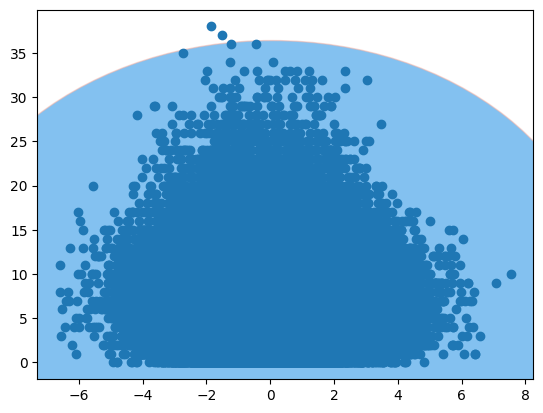

f26 - f12 	Index of Outliers:  [10925 55654]


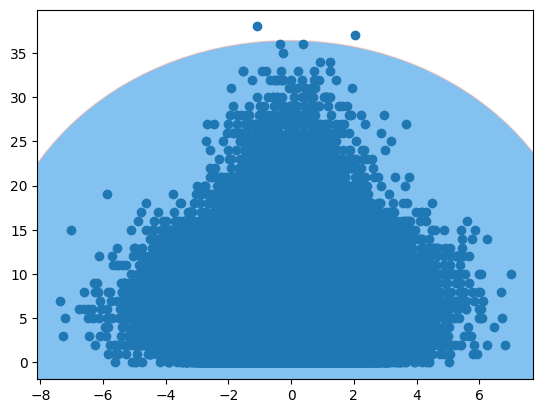

f27 - f12 	Index of Outliers:  [ 2970 10925 55654]


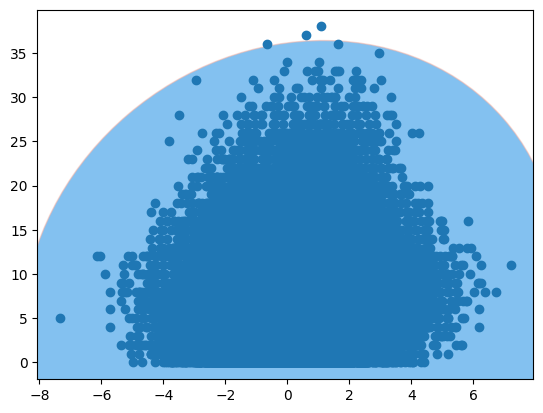

In [20]:
for i in range(28):
    if i != 12:
        f1 = 'f{}'.format(i)
        mahalanobis_distance(df, f1, 'f12')